## Explanation 2 - distribution fitting 

In this and the previous document an explanation on how to import and clear the data and how to perform distribution fitting with Python is provided.

The *Colorado River case study* is taken as a reference. 

This second document focuses on the distribution fitting using both Gumbel and GEV.

Let's first import the required libraries.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sci

%matplotlib inline

In the next lines we will import the data and clear them in order to get a usable DataFrame. The procedure is the same as presented in the previous document *Explanation 1 - import and clear the data*, so you can skip this part. 
\
In case you need further information refer to that document.  

In [2]:
df = pd.read_csv('Colorado river.txt', skiprows = 49, header = 0,  sep='\t').drop(['agency_cd', 'site_no'], axis = 1).drop([0], axis = 0)

df.drop(df.columns[12:], axis =1, inplace = True)
df.drop(df.columns[1:3], axis = 1, inplace = True)
df.drop(df.columns[1:3], axis = 1, inplace = True)
df.drop(df.columns[2:7], axis = 1, inplace = True)

df.rename(columns = {'datetime': 'Date',
                     '142741_00060_00003': r'Discharge $(m^3 s^{-1})$',
                     '142745_80155_00003': r'Suspended sediment discharge $(ton$ $day^{-1})$'
                     }, inplace = True)

col = df.columns.values

df[col[1]] = df[col[1]].astype('int') * 0.0283168
df[col[2]] = df[col[2]].astype('float') * 0.91
df['Date'] = pd.to_datetime(df['Date'])
df

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3505: DtypeWarning: Columns (1,3,5,7,9,11,12,13,14,15,17,19,21,23,25,27,29,31,33,35,37,39,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
1,1949-05-01,685.26656,131040.0
2,1949-05-02,600.31616,46865.0
3,1949-05-03,557.84096,24206.0
4,1949-05-04,659.78144,182910.0
5,1949-05-05,696.59328,497770.0
...,...,...,...
27040,2023-05-12,857.99904,NaN
27041,2023-05-13,866.49408,NaN
27042,2023-05-14,914.63264,NaN
27043,2023-05-15,954.27616,NaN


Now we can start with the distribution fitting process.

We will fit the extreme values recorded of water discharge, therefore we need to determine an approach to sample them.

The chosen method is the *Block Maxima*, which requires to divide the observation period in a certain number of blocks with the same duration (i.e., with the same amount of data). The length of the blocks depends on the dataset we are working on, the duration of the measurements and so on. Once data are split into these blocks, we sample the maximum value for each of them. Therefore, if we divide our dataset into *N* blocks we will end up having *N* extreme values.

For this assignment we have decided to sample the yearly maxima, which means that for each year of measurements the maximum value will be sampled.

We define the function `yearly_maxima` to sample the extremes.

This function first rearranges the data based on the year of the record, then for each year finds the index of the maximum value of the chosen column and finally creates a list with the recorded values corresponding to the maxima indices. 

The `column` argument is included because in this way we can choose to apply the function both to water discharge and to suspended sediment discharge if required. 

In [3]:
def yearly_maxima(data, column):
    '''
    Function that samples the yearly maximum of parameters in data frame for the requested column index
    '''
    col = data.columns.values
    idx_max = data.groupby(pd.DatetimeIndex(data[col[0]]).year)[col[column]].idxmax()
    max_list = data.loc[idx_max]
    return max_list

Now we apply the function only on water discharge and then we plot the result.

Note: the new DataFrame also includes the suspended sediment discharge records related to the sampled water discharge extremes. 

In [4]:
yearly_maxima_discharge = yearly_maxima(df, 1) 
yearly_maxima_discharge

,Date,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
52,1949-06-21,1506.45376,91910.0
400,1950-06-04,659.78144,133770.0
760,1951-05-30,824.01888,285740.0
1137,1952-06-10,1594.23584,182000.0
1507,1953-06-15,1076.03840,100100.0
...,...,...,...
25608,2019-06-10,1107.18688,NaN
25966,2020-06-02,421.92032,NaN
26336,2021-06-07,235.02944,NaN
26683,2022-05-20,455.90048,NaN


We can plot the sampled extremes (red circles) together with the whole time series.

C:\Users\anton\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


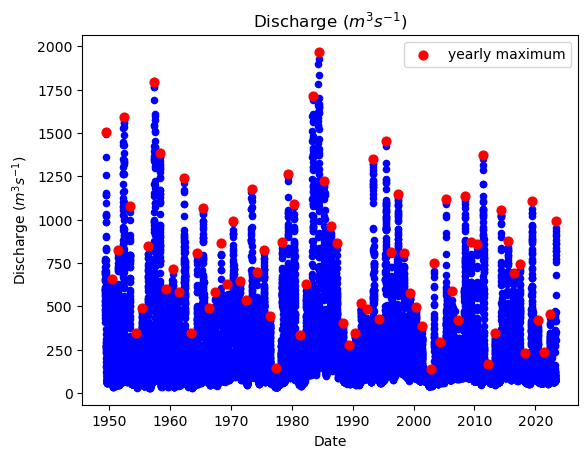

In [5]:
df.plot(kind = 'scatter', x = 'Date', y = col[1], color = 'b')
plt.scatter(yearly_maxima_discharge['Date'], yearly_maxima_discharge[col[1]], 40, 'r', label='yearly maximum')
plt.title(col[1])
plt.legend(loc='best')

Once the extremes are sampled, we can proceed with the fitting of a distribution which can be used for forecasting future and in general unrecorded (extreme) values.

First, let's show the main statistics of the initial (and complete) dataframe and later only of the one containing the water discharge extremes (and the related suspended sediment discharge).

In [6]:
df.describe()

,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
count,27044.000000,12936.000000
mean,183.631432,22731.557587
std,201.007337,55728.286699
min,28.316800,12.740000
25%,82.118720,705.022500
50%,111.851360,2275.000000
75%,178.679008,15470.000000
max,1968.017600,910000.000000


In [7]:
yearly_maxima_discharge.describe()

,Discharge $(m^3 s^{-1})$,Suspended sediment discharge $(ton$ $day^{-1})$
count,75.000000,36.000000
mean,788.815434,134329.144444
std,414.193874,79077.593308
min,135.637472,7935.200000
25%,470.058880,81649.750000
50%,741.900160,130585.000000
75%,1071.790880,166302.500000
max,1968.017600,328510.000000


It's quite evident that the dataframe containing the yearly extremes has higher values for all percentiles, and the same holds for the related suspended sediment values.

At this point we need to compute the empirical cumulative distribution (ECDF), based on the observations we have.

We create the function `calculate_ecdf` for convenience.

This function initially sorts the data in ascending order (from the smallest to the largest) depending on the column we want to sort. Then it resets the index because after data are sorted the indices are associated to the sampled values, therefore our new DataFrame will no longer have ordered indices. Eventually it computes the value of the Cumulative Density Function (CDF) for each data simply dividing the index by the total amount of data: $F(x_i)=\frac{i}{N+1}$.

In [8]:
def calculate_ecdf(extreme_value_data, column):
    """
    Fit an emperical cumulative distribution function to known values for a given column index 
    """
    col = extreme_value_data.columns.values          
      
    sorted_data = extreme_value_data.sort_values(by = col[column], ascending=True)

    sorted_data.reset_index(drop=True, inplace=True)     
        
    sorted_data.index = sorted_data.index + 1      
      
    N = len(sorted_data[col[column]])       
    
    sorted_data['F_x'] = sorted_data.index / (N + 1)     
    
    ecdf = sorted_data[['F_x', col[column]]]   
         
    return ecdf 

We also create a function for plotting the results.

In [9]:
def plot_density_functions(empirical_df, x, pdf, cdf, CI_1, CI_2, quantiles, method, curve):
    '''
    Plots pdf, cdf, return period and QQ plot for a given function. Confidence intervals are included in 
    return period graph.
    '''
    # pdf
    empirical_df.hist(col[1], density = True, label = 'Empirical Histogram', color='b')
    plt.title('PDF from' + method + 'using' + curve) 
    plt.plot(x, pdf, 'r', label = 'Fitted' + curve)
    plt.ylabel('f(x)') 
    plt.xlabel(col[1]) 
    plt.grid() 
    plt.legend()
    if curve == ' genextreme': plt.yscale('log')
    plt.show()

    # cdf
    plt.scatter(empirical_df[col[1]], empirical_df['F_x'], 40, 'k', label = 'Empirical cdf') 
    plt.title('CDF from' + method + 'using' + curve) 
    plt.plot(empirical_df[col[1]], cdf, 'r', label = 'Fitted' + curve)
    plt.ylabel('F(x)') 
    plt.xlabel(col[1]) 
    plt.grid() 
    plt.legend()
    plt.ylim([0, 1])
    plt.show()

    # inv cdf
    plt.scatter(1 / (1 - empirical_df['F_x']), empirical_df[col[1]], 40, 'k', label = 'Empirical inverse cdf') 
    plt.title('Return Period from' + method + 'using' + curve) 
    plt.plot(1 / (1 - cdf), empirical_df[col[1]], 'r', label = 'Fitted' + curve)
    plt.plot(1 / (1 - CI_1), empirical_df[col[1]], 'b', label = 'CI' + curve) 
    plt.plot(1 / (1 - CI_2), empirical_df[col[1]], 'b') 
    plt.xlabel('Return Period [years]') 
    plt.ylabel(col[1]) 
    plt.xscale('log')
    plt.grid() 
    plt.legend()
    plt.show()
    
    # QQ Plot
    empirical_quantiles = empirical_df[col[1]]

    plt.figure(figsize = (6, 6))
    plt.scatter(empirical_quantiles, quantiles, 40, 'k', label = curve)
    linear = np.array([250, 2000])
    plt.plot(linear, linear, label = 'Perfect fit')
    plt.title('QQ-plot for' + curve)
    plt.ylabel(r'Theoretical quantiles (Discharge [$m^3$ $s^{-1}$])')
    plt.xlabel(r'Empirical quantiles (Discharge [$m^3$ $s^{-1}$])')
    plt.grid()
    plt.legend()
    plt.show()

Now we can determine the ECDF for the water discharge maxima. 

In [10]:
ecdf_blockmax = calculate_ecdf(yearly_maxima_discharge, 1)
ecdf_blockmax.head()

,F_x,Discharge $(m^3 s^{-1})$
1,0.013158,135.637472
2,0.026316,140.734496
3,0.039474,165.936448
4,0.052632,231.348256
5,0.065789,235.029440


At this point we can introduce the Gumbel distribution. 
\
This is a typical distribution used for modelling the maxima (or minima) sampled from a given dataset.

The probability density function of Gumbel distribution is $f(x)=\frac{1}{\beta}e^{-z-e^{-z}}$, the cumulative density function is $F(x)=e^{-e^{-z}}$, with $z=\frac{x-\alpha}{\beta}$.

For this assignment we make use of the `scipy.stats` library, which contains the `gumbel_r` function. This function is used for modelling a right-skewed Gumbel continuous random variable. For more information see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_r.html.

First, we define a function that computes the parameters $\alpha$ and $\beta$ of the Gumbel distribution.

$\gamma=0.5772156649$ is Euler's constant.

In [11]:
gamma = 0.5772156649   

def alpha_beta(data):   
    '''
    Function that computes the Gumbel parameters alpha and beta'''
    beta = (np.sqrt(6) * np.std(data)) / (np.pi)
    alpha = np.mean(data) - gamma * beta
    return alpha, beta

Now we can define the functions to compute the Gumbel PDF, CDF and PPF.

In [12]:
def gumbel_pdf(data, x):
    '''
    Function that computes the Gumbel PDF

    Input: data = data
           x    = spacing of output
    
    Output: pdf = Gumbel PDF
    '''
    alpha, beta = alpha_beta(data)

    pdf = sci.gumbel_r.pdf(x, loc = alpha, scale = beta)
    return pdf

In [13]:
def gumbel_cdf(data, x):
    '''
    Function that computes the Gumbel CDF

    Input: data = data
           x    = spacing of output
    
    Output: pdf = Gumbel CDF
    '''
    alpha, beta = alpha_beta(data)

    cdf = sci.gumbel_r.cdf(x, loc = alpha, scale = beta)
    return cdf

In [14]:
def gumbel_ppf(data, probability):
    '''
    Function that computes the Gumbel CDF

    Input: data = data
           probability = emperical cdf of data
           x    = spacing of output
    
    Output: pdf = Gumbel CDF
    '''
    alpha, beta = alpha_beta(data)

    ppf = sci.gumbel_r.ppf(probability, loc = alpha, scale = beta)
    return ppf

Now that the Gumbel distribution has been modelled, we are ready for properly fitting the observations, but before doing that we define a spacing array for making the functions work.

In [15]:
spacing = np.linspace(min(ecdf_blockmax[col[1]]), max(ecdf_blockmax[col[1]]), len(ecdf_blockmax[col[1]]))

Now way we can compute the PDF, CDF and PPF of the sampled extremes.

In [16]:
gum_pdf = gumbel_pdf(ecdf_blockmax[col[1]], spacing)
gum_cdf = gumbel_cdf(ecdf_blockmax[col[1]], ecdf_blockmax[col[1]])
gum_ppf = gumbel_ppf(ecdf_blockmax[col[1]], ecdf_blockmax['F_x'])

We also include the confidence intervals, by computing the 95% percentile and later add it to the plot.  

In [17]:
sigma = 0.05 * ecdf_blockmax[col[1]]
k95 = sci.norm.ppf(1-0.05/2)
k95_sig = k95*sigma

gum_cdf_ci1 = gumbel_cdf(ecdf_blockmax[col[1]] + k95_sig, ecdf_blockmax[col[1]])
gum_cdf_ci2 = gumbel_cdf(ecdf_blockmax[col[1]] - k95_sig, ecdf_blockmax[col[1]])

We can plot the results.

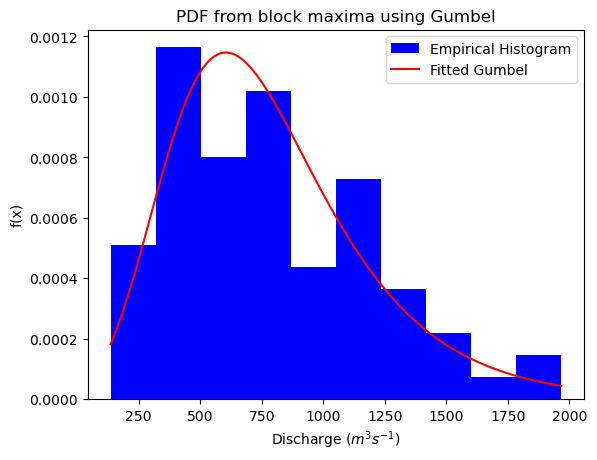

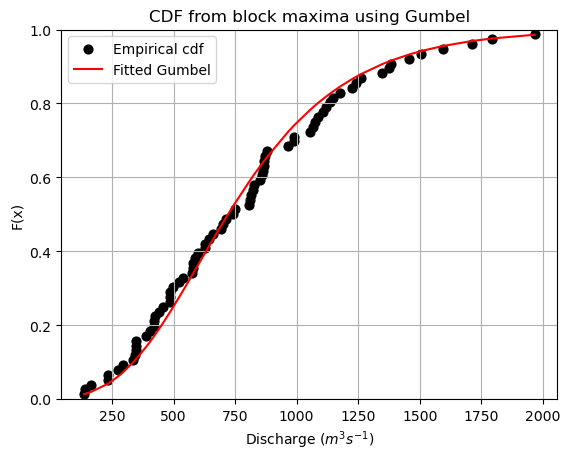

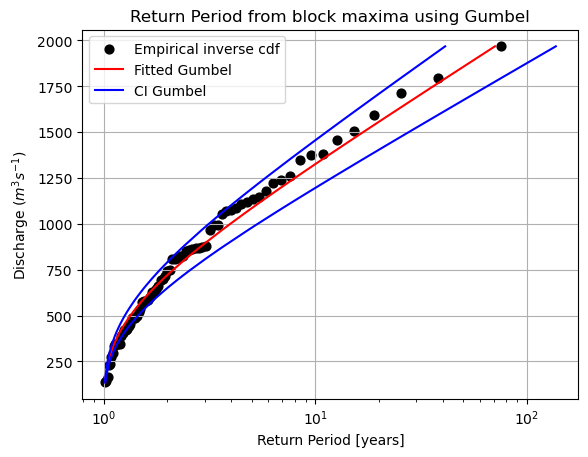

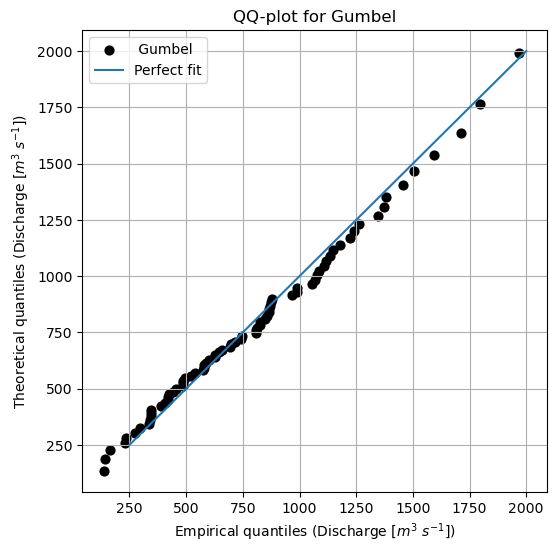

In [18]:
plot_density_functions(ecdf_blockmax, spacing, gum_pdf, gum_cdf, gum_cdf_ci1, gum_cdf_ci2, gum_ppf, ' block maxima ', ' Gumbel')

The results look pretty good, don't they?

Now we repeat the same procedure with a GEV (Generalized Extreme Value) distribution. Again, we make use of the `scipy.stats` library, which contains the `genextreme` set of functions for these purposes. For more info on this library see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html.

We start computing the three parameters required for the fit. The method we use for the fit is the `mle`, whihc stands for Maximum Likelihood Estimation method.

In [19]:
GEV_param_blockmax = sci.genextreme.fit(ecdf_blockmax[col[1]], method = 'mle')

Once the parameters are computed, we use them for determining the PDF, CDF, and the quantiles (PPF) of the GEV.

In [20]:
GEV_pdf = sci.genextreme.pdf(spacing, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf = sci.genextreme.cdf(ecdf_blockmax[col[1]], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_quantiles = sci.genextreme.ppf(ecdf_blockmax['F_x'], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

Again, we include the 95% confidence intervals.

In [21]:
GEV_cdf_ci1 = sci.genextreme.cdf(ecdf_blockmax[col[1]] + k95_sig, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf_ci2 = sci.genextreme.cdf(ecdf_blockmax[col[1]] - k95_sig, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

And we plot the results.

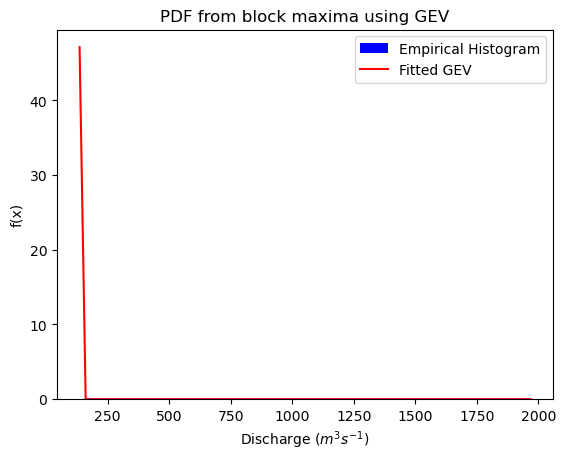

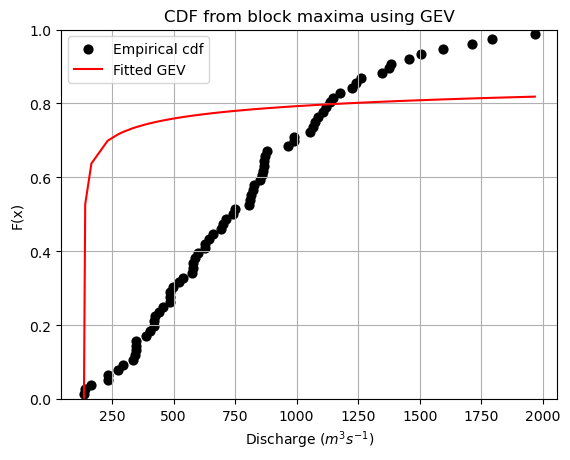

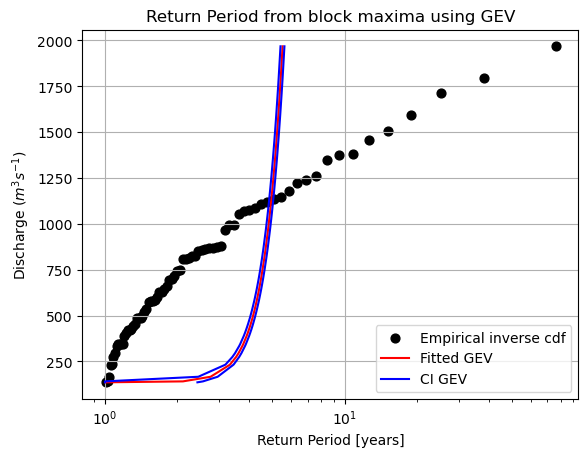

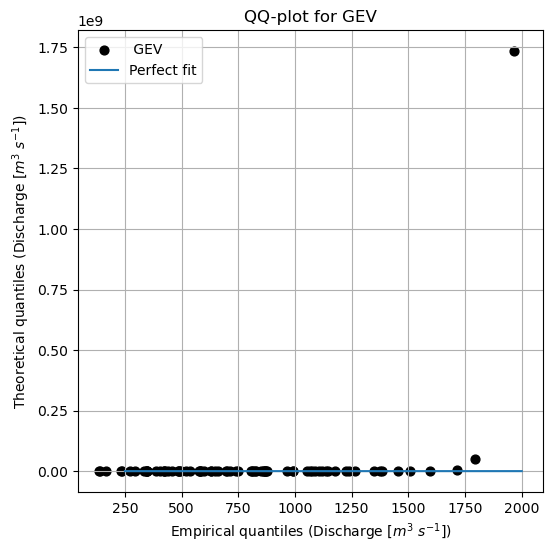

In [22]:
plot_density_functions(ecdf_blockmax, spacing, GEV_pdf, GEV_cdf, GEV_cdf_ci1, GEV_cdf_ci2,  GEV_quantiles, ' block maxima ', ' GEV')

Clearly, something went wrong! But what can the issue be? 

The procedure we have followed is the same: define the parameters of the distribution, define the PDF, CDF, and PPF functions and compute them. However, this time the results don't look good at all. Why is that?

The `genextreme.fit` function determines the GEV parameters based on the dataset we have, in our case the `ecdf_blockmax[col[1]]`.

Therefore, the problem might be somehow related to the dataset (as we have seen, the procedure we have applied is exactly the same).

Let's print the dataset and the main statistics to see if we can identify the issue.

In [23]:
print(ecdf_blockmax[col[1]])

1      135.637472
2      140.734496
3      165.936448
4      231.348256
5      235.029440
         ...     
71    1506.453760
72    1594.235840
73    1713.166400
74    1795.285120
75    1968.017600
Name: Discharge $(m^3 s^{-1})$, Length: 75, dtype: float64


In [24]:
ecdf_blockmax[col[1]].describe()

count      75.000000
mean      788.815434
std       414.193874
min       135.637472
25%       470.058880
50%       741.900160
75%      1071.790880
max      1968.017600
Name: Discharge $(m^3 s^{-1})$, dtype: float64

Ok, it might seem that these numbers don't give us useful information for understanding the reason why the fit does not work.
\
However, if we look carefully at the time series plot containing the sampled extrems, we can notice that some of them (around 4-5 data points) are extremely low values, sometimes even lower than many other non-extreme values (consider for instance the red points between 1970-1980, 2000-2010 and 2010-2020). It might be the case that those values are so low such that the fit function gets "confused".

For this reason we can try removing the lowest point, that means the first item of the `ecdf_blockmax[col[1]]`, and then repeat the same procedure.

For convenience, we just rename the arrays that we don't want to be updated (for instance `spacing`) as it might turn out to be used later on for comparing the quality of the two fits.

The next code space is the exact same code as before, the only difference is in the `ecdf_blockmax` array .

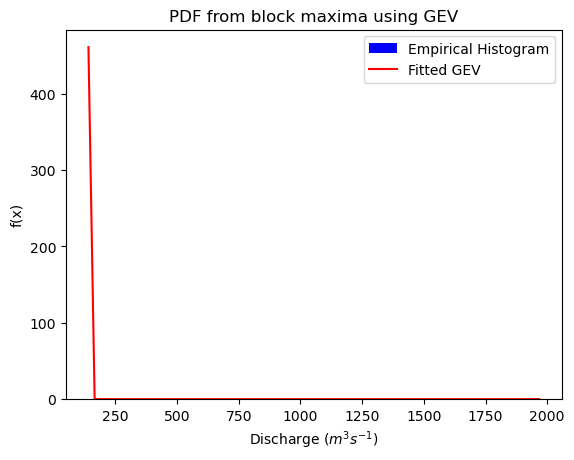

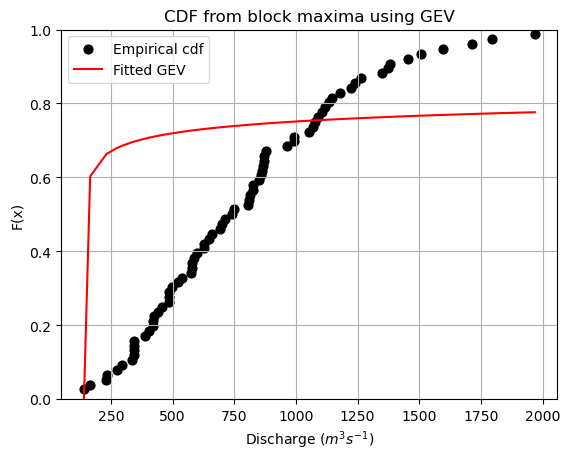

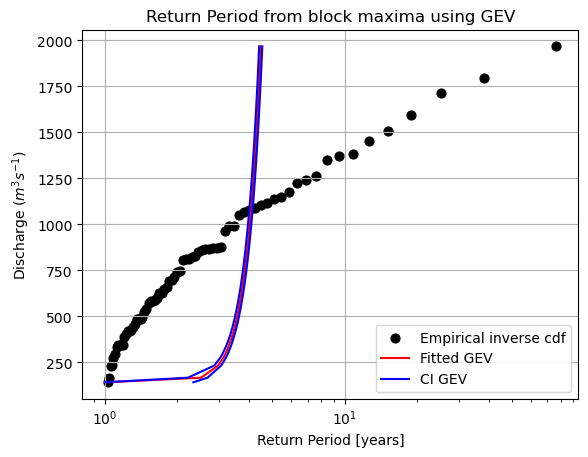

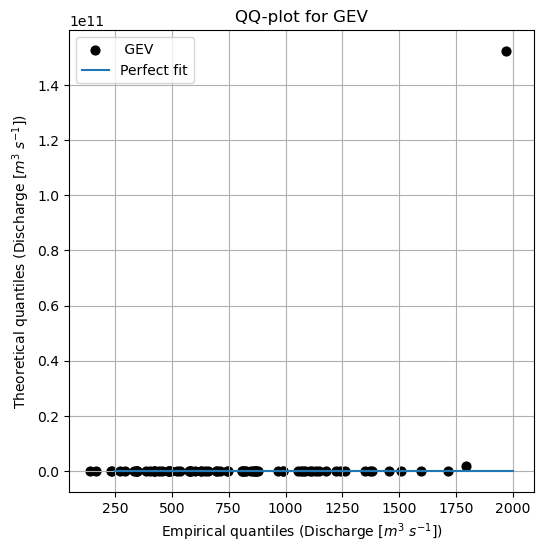

In [25]:
ecdf_blockmax_new = ecdf_blockmax[1:]

spacing_new = np.linspace(min(ecdf_blockmax_new[col[1]]), max(ecdf_blockmax_new[col[1]]), len(ecdf_blockmax_new[col[1]]))

GEV_param_blockmax = sci.genextreme.fit(ecdf_blockmax_new[col[1]], method = 'mle')

GEV_pdf = sci.genextreme.pdf(spacing_new, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf = sci.genextreme.cdf(ecdf_blockmax_new[col[1]], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_quantiles = sci.genextreme.ppf(ecdf_blockmax_new['F_x'], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

sigma_new = 0.05 * ecdf_blockmax_new[col[1]]
k95_new = sci.norm.ppf(1-0.05/2)
k95_sig_new = k95_new*sigma_new

GEV_cdf_ci1 = sci.genextreme.cdf(ecdf_blockmax_new[col[1]] + k95_sig_new, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf_ci2 = sci.genextreme.cdf(ecdf_blockmax_new[col[1]] - k95_sig_new, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

plot_density_functions(ecdf_blockmax_new, spacing_new, GEV_pdf, GEV_cdf, GEV_cdf_ci1, GEV_cdf_ci2,  GEV_quantiles, ' block maxima ', ' GEV')

The result looks exactly the same as before. The fit still does not work properly.

We can try removing also the second data point and repeating the same procedure. 

Note: you can achieve the same result by deleting the first data point of the new array `ecdf_blockmax_new` instead of deleting the first two data points of the initial array `ecdf_blockmax`.

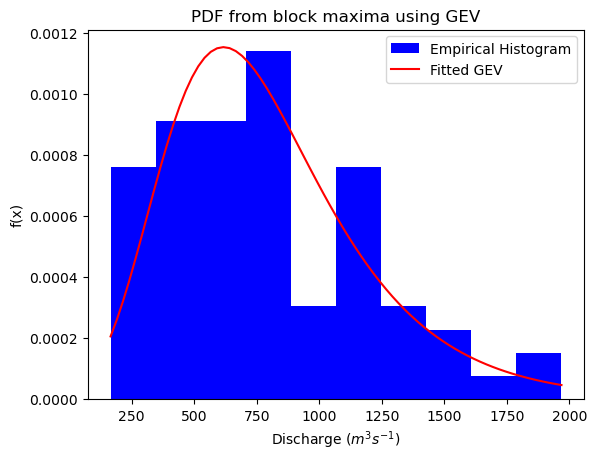

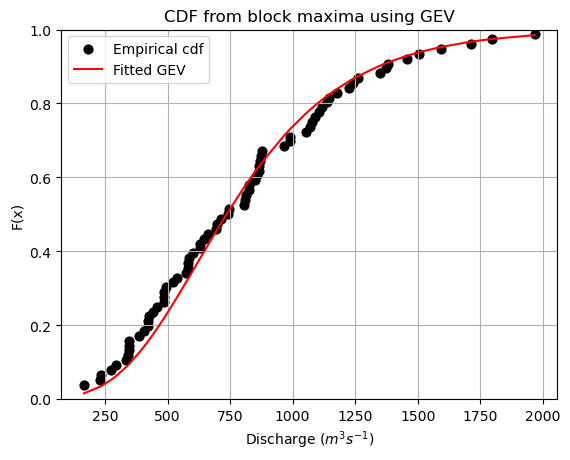

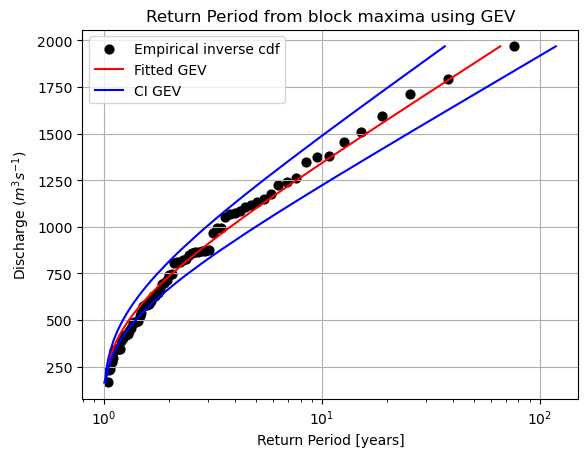

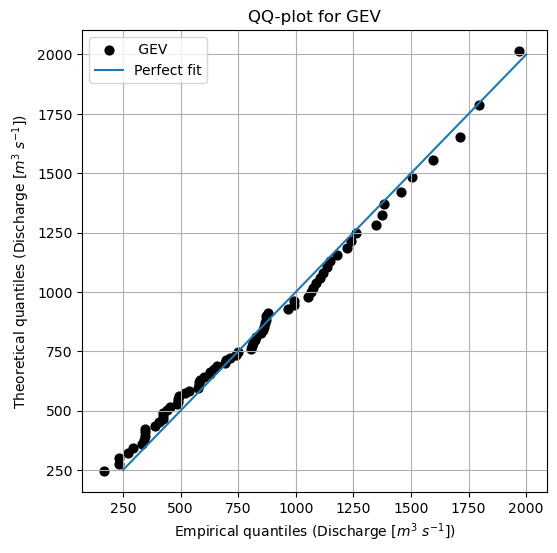

In [26]:
ecdf_blockmax_new = ecdf_blockmax[2:]

spacing_new = np.linspace(min(ecdf_blockmax_new[col[1]]), max(ecdf_blockmax_new[col[1]]), len(ecdf_blockmax_new[col[1]]))

GEV_param_blockmax = sci.genextreme.fit(ecdf_blockmax_new[col[1]], method = 'mle')

GEV_pdf = sci.genextreme.pdf(spacing_new, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf = sci.genextreme.cdf(ecdf_blockmax_new[col[1]], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_quantiles = sci.genextreme.ppf(ecdf_blockmax_new['F_x'], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

sigma_new = 0.05 * ecdf_blockmax_new[col[1]]
k95_new = sci.norm.ppf(1-0.05/2)
k95_sig_new = k95_new*sigma_new

GEV_cdf_ci1 = sci.genextreme.cdf(ecdf_blockmax_new[col[1]] + k95_sig_new, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf_ci2 = sci.genextreme.cdf(ecdf_blockmax_new[col[1]] - k95_sig_new, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

plot_density_functions(ecdf_blockmax_new, spacing_new, GEV_pdf, GEV_cdf, GEV_cdf_ci1, GEV_cdf_ci2,  GEV_quantiles, ' block maxima ', ' GEV')

That's way better! The results now look promising and the fit is clearly more representative of the dataset.

If you wish, you can remove also the third point and see how the fit changes. Does it look better?

Actually, in the *Colorado River case study* this whole process waas implemented inside the function `calculate_ecdf`. Specifically, the line `sorted_data = sorted_data[2:]` is the one that deletes the first two entries of the dataset we are working with in order to imporve the goodness of the fit.

In this document we have explained it in a longer but hopefully clearer way and both solutions are correct.

However, in order to compare the two fits, we must bear in mind that we should have "comparable" objects. This means that we should not compare the result of a full dataset (the Gumbel one) with the result of a partial dataset (the GEV one).

For this reason we decide to work only with the partial dataset, without considering the first two entries.
\
In the next lines we will define again the function `calculate_ecdf` but now it will automatically get rid of the first two data points, as implemented in the *Colorado River case study*. Then we will repeat the same procedure as done before and later it will be possible to compare the results.

In [27]:
def calculate_ecdf(extreme_value_data, column):
    """
    Fit an emperical cumulative distribution function to known values for a given column index 
    """
    col = extreme_value_data.columns.values          
    
    sorted_data = extreme_value_data.sort_values(by = col[column], ascending=True)

    sorted_data = sorted_data[2:] 

    sorted_data.reset_index(drop=True, inplace=True)     
        
    sorted_data.index = sorted_data.index + 1      
        
    N = len(sorted_data[col[column]])       
    
    sorted_data['F_x'] = sorted_data.index / (N + 1)     
    
    ecdf = sorted_data[['F_x', col[column]]]   
         
    return ecdf 

We compute again the `ecdf_blockmax` and `spacing` array (we don't mind about updating the original arrays, as we will do the whole process from the beginning).

In [28]:
ecdf_blockmax = calculate_ecdf(yearly_maxima_discharge, 1)

spacing = np.linspace(min(ecdf_blockmax[col[1]]), max(ecdf_blockmax[col[1]]), len(ecdf_blockmax[col[1]]))

We compute the Gumbel fit and the GEV fit, respectively, and plot them.

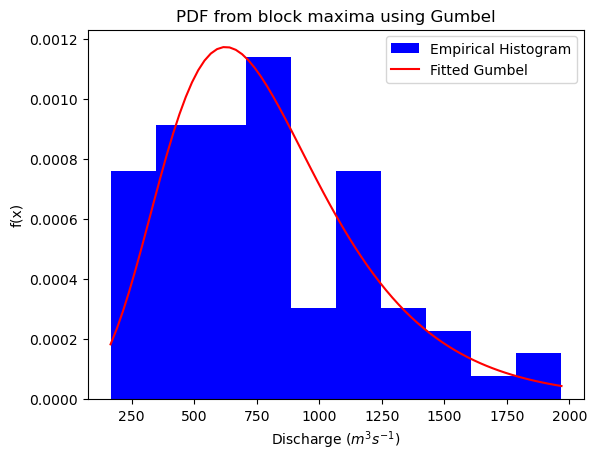

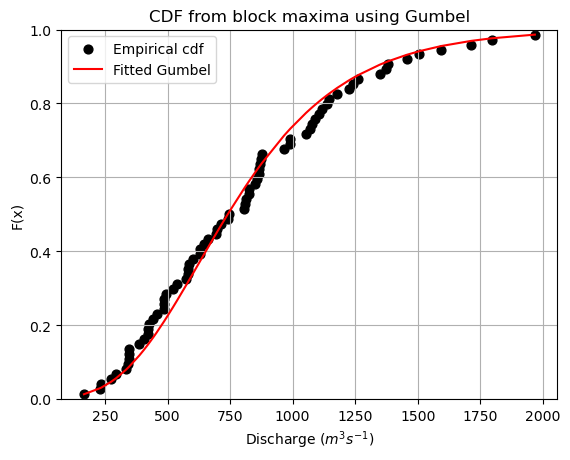

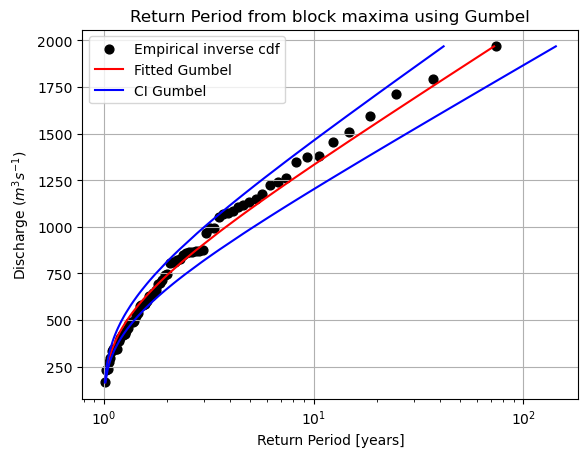

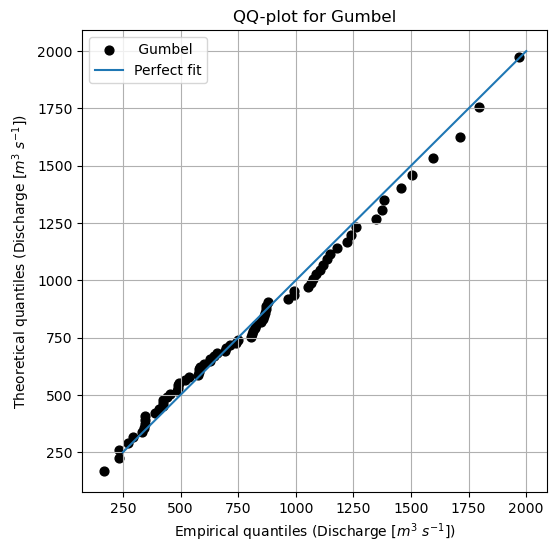

In [29]:
gum_pdf = gumbel_pdf(ecdf_blockmax[col[1]], spacing)
gum_cdf = gumbel_cdf(ecdf_blockmax[col[1]], ecdf_blockmax[col[1]])
gum_ppf = gumbel_ppf(ecdf_blockmax[col[1]], ecdf_blockmax['F_x'])

sigma = 0.05 * ecdf_blockmax[col[1]]
k95 = sci.norm.ppf(1-0.05/2)
k95_sig = k95*sigma

gum_cdf_ci1 = gumbel_cdf(ecdf_blockmax[col[1]] + k95_sig, ecdf_blockmax[col[1]])
gum_cdf_ci2 = gumbel_cdf(ecdf_blockmax[col[1]] - k95_sig, ecdf_blockmax[col[1]])

plot_density_functions(ecdf_blockmax, spacing, gum_pdf, gum_cdf, gum_cdf_ci1, gum_cdf_ci2, gum_ppf, ' block maxima ', ' Gumbel')

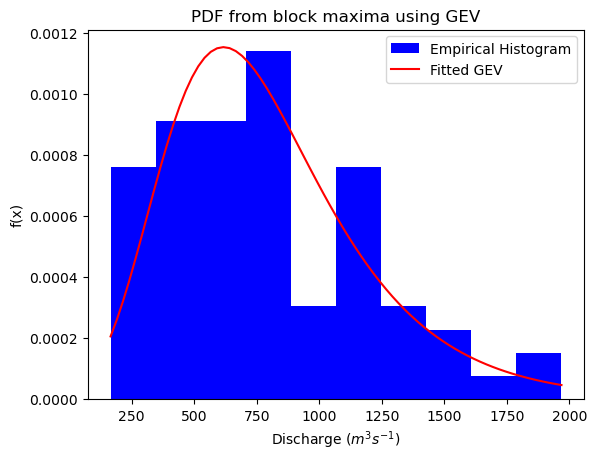

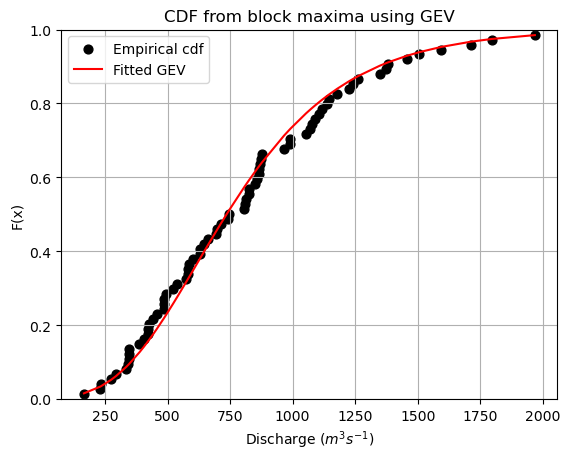

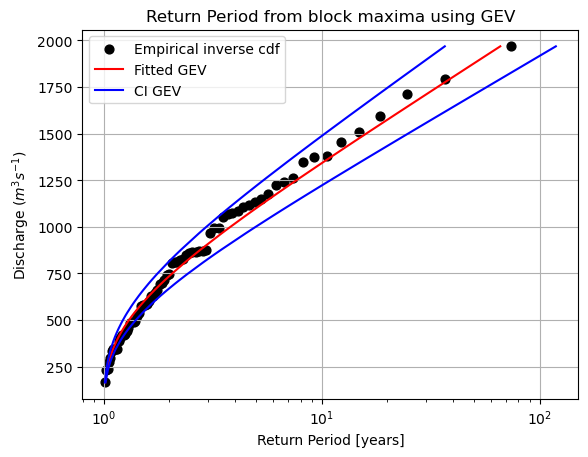

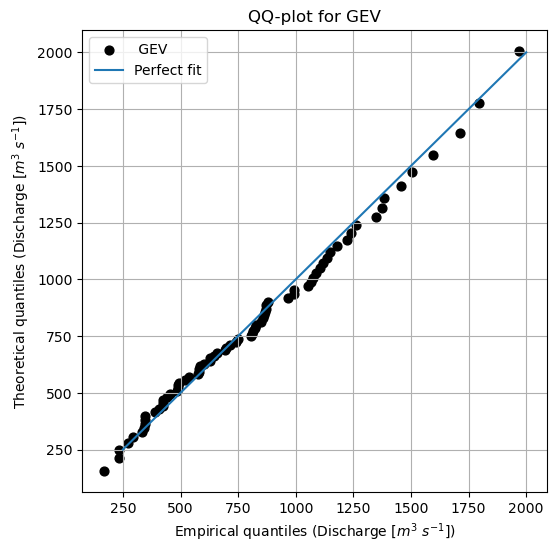

In [30]:
GEV_param_blockmax = sci.genextreme.fit(ecdf_blockmax[col[1]], method = 'mle')

GEV_pdf = sci.genextreme.pdf(spacing, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf = sci.genextreme.cdf(ecdf_blockmax[col[1]], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_quantiles = sci.genextreme.ppf(ecdf_blockmax['F_x'], GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

GEV_cdf_ci1 = sci.genextreme.cdf(ecdf_blockmax[col[1]] + k95_sig, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])
GEV_cdf_ci2 = sci.genextreme.cdf(ecdf_blockmax[col[1]] - k95_sig, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

plot_density_functions(ecdf_blockmax, spacing, GEV_pdf, GEV_cdf, GEV_cdf_ci1, GEV_cdf_ci2,  GEV_quantiles, ' block maxima ', ' GEV')

As we can see, both results look promising but we already knew that! 

For comparing the quality of the fit and the relative goodness between the Gumbel and the GEV fit we plot them in terms of $Return$ $Period$ $(years)$ and on a log-scale axis.

We define the array `ext_spacing` in order to make predictions and extend the Gumbel and GEV cumulative distribution functions.

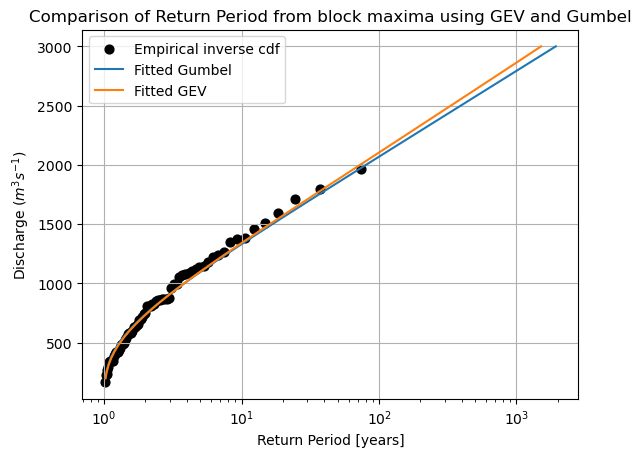

In [31]:
ext_spacing = np.linspace(200, 3000)
gum_cdf_ext = gumbel_cdf(ecdf_blockmax[col[1]], ext_spacing)
GEV_cdf_ext = sci.genextreme.cdf(ext_spacing, GEV_param_blockmax[0], GEV_param_blockmax[1], GEV_param_blockmax[2])

plt.scatter(1 / (1 - ecdf_blockmax['F_x']), ecdf_blockmax[col[1]], 40, 'k', label = 'Empirical inverse cdf')
plt.title('Comparison of Return Period from block maxima using GEV and Gumbel') 
plt.plot(1 / (1 - gum_cdf_ext), ext_spacing, label = 'Fitted Gumbel')
plt.plot(1 / (1 - GEV_cdf_ext), ext_spacing, label = 'Fitted GEV')
plt.xlabel('Return Period [years]') 
plt.ylabel(col[1]) 
plt.xscale('log')
plt.grid() 
plt.legend()
plt.show()

It is quite evident that both fits work quite good for the given dataset, especially for the lower values ($RT<10^{1}\hspace{0.75mm}years$).

If we are supposed to use one of them for future predictions, the GEV fit is the best one to be chosen because it is slightly more conservative than the Gumbel one (for the same $RT$ it provides a slightly larger values of the water discharge $Q$).

Moreover, we must also notice that the (right-skewed) Gumbel distribution is nothing but a particular GEV distribution for which the shape parameter $\xi=0$ (type I distribution), and that's why given the same dataset the two fits look pretty the same.  